# Road Segmentation Module Testing

This notebook provides a comprehensive testing framework for the road segmentation module from the rockfall risk assessment project. We'll test the functionality for dividing road networks into equal-length segments for uniform analysis in rockfall risk assessment.

## 1. Introduction and Setup <a id="setup"></a>

The road segmentation module provides functionality to divide road networks into equal-length segments for uniform analysis in rockfall risk assessment.

In [3]:
# Add parent directory to path so we can import project modules.
import os
import sys
from pathlib import Path

# Get parent directory (project root)
project_root = Path.cwd().parent
sys.path.append(str(project_root))

print(f"Project root directory: {project_root}")

Project root directory: /Users/giandomenico/Documents/SAPIENZA/Python Scripts/rockfall_risk_roads


In [4]:
# Import standard libraries
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import LineString, MultiLineString, Point
import time
import logging
import warnings

# Import project modules
from src.road.segmentation import segment_road, segment_road_network, dissolve_segments
from src.utils.io_utils import read_vector, write_vector

# Configure logging
logging.basicConfig(level=logging.INFO, 
                   format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
logger = logging.getLogger('road_segmentation_testing')

# Set plot parameters
plt.rcParams['figure.figsize'] = (12, 8)

# Suppress warnings
warnings.filterwarnings('ignore', category=UserWarning)

print("Setup complete.")

Setup complete.


## 2. Load Sample Data <a id="load-data"></a>

We'll load the road network data from the input directory using the io_utils module. The main dataset is `tr_str.gpkg`, which contains the road network for our study area.

In [5]:
# Define data paths
data_dir = project_root / "data"
input_dir = data_dir / "input"
road_file = input_dir / "tr_str.gpkg"

# Load road network data
try:
    road_network = read_vector(str(road_file))
    print(f"Successfully loaded road network data: {len(road_network)} features")
except Exception as e:
    print(f"Error loading road network data: {e}")
    # In case of failure, try loading without specifying CRS
    road_network = gpd.read_file(road_file)
    print(f"Loaded road network with original CRS: {road_network.crs}")

Successfully loaded road network data: 330 features


In [6]:
# Explore the data structure
print("\nRoad network data schema:")
print(road_network.dtypes)

print("\nSample road network features:")
road_network.head()


Road network data schema:
OBJECTID       float64
tr_str_sed      object
tr_str_fon      object
tr_str_liv      object
tr_str_sta      object
tr_str_ty       object
scril           object
tr_str_med      object
tr_str_nom      object
tr_str_ped      object
tr_str_cf       object
classid         object
tr_str_cl       object
meta_ist        object
shape_Leng     float64
segment_id       int64
geometry      geometry
dtype: object

Sample road network features:


,OBJECTID,tr_str_sed,tr_str_fon,tr_str_liv,tr_str_sta,tr_str_ty,scril,tr_str_med,tr_str_nom,tr_str_ped,tr_str_cf,classid,tr_str_cl,meta_ist,shape_Leng,segment_id,geometry
0,178.0,01,01,02,01,01,None,02,SP40B,02,04,None,03,04,10.687781,178,MULTILINESTRING Z ((341732.048 4643301.823 0.0...
1,697.0,01,01,02,01,01,None,02,UNK,02,05,None,01,04,158.698816,697,MULTILINESTRING Z ((343512.471 4638415.962 0.0...
2,1296.0,01,01,02,01,01,None,02,UNK,02,05,None,01,04,256.024063,1296,MULTILINESTRING Z ((342173.621 4638708.141 0.0...
3,1526.0,01,01,02,01,01,None,02,UNK,02,06,None,02,04,342.128712,1526,MULTILINESTRING Z ((341916.712 4643767.214 0.0...
4,3323.0,01,01,02,01,01,None,02,UNK,02,06,None,02,04,66.320093,3323,MULTILINESTRING Z ((342151.991 4643646.136 0.0...


Road length statistics (meters):
count     330.000000
mean      227.577853
std       532.778168
min         1.071572
25%        23.642211
50%        78.967597
75%       222.217476
max      7330.189635
Name: length_m, dtype: float64


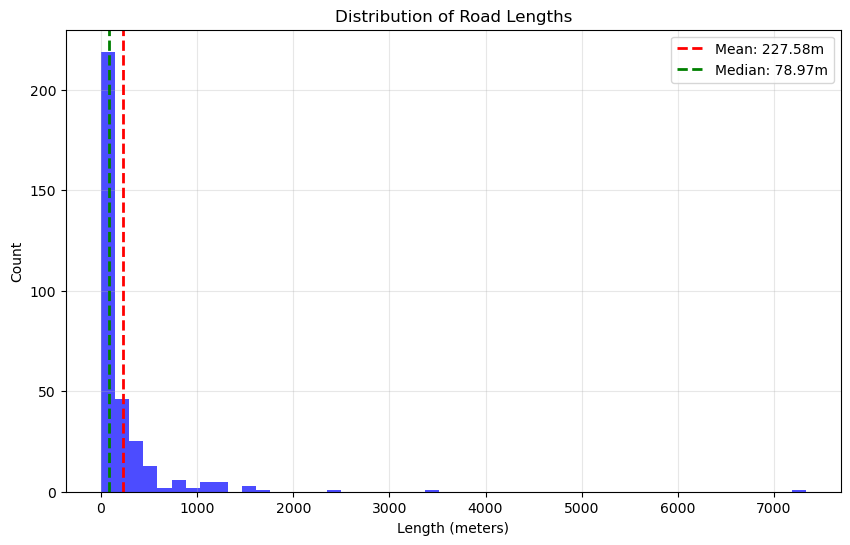

In [7]:
# Basic statistics of road lengths
road_network['length_m'] = road_network.geometry.length
length_stats = road_network['length_m'].describe()
print("Road length statistics (meters):")
print(length_stats)

# Create a histogram of road lengths
plt.figure(figsize=(10, 6))
plt.hist(road_network['length_m'], bins=50, alpha=0.7, color='blue')
plt.title('Distribution of Road Lengths')
plt.xlabel('Length (meters)')
plt.ylabel('Count')
plt.axvline(length_stats['mean'], color='red', linestyle='dashed', linewidth=2, label=f'Mean: {length_stats["mean"]:.2f}m')
plt.axvline(length_stats['50%'], color='green', linestyle='dashed', linewidth=2, label=f'Median: {length_stats["50%"]:.2f}m')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

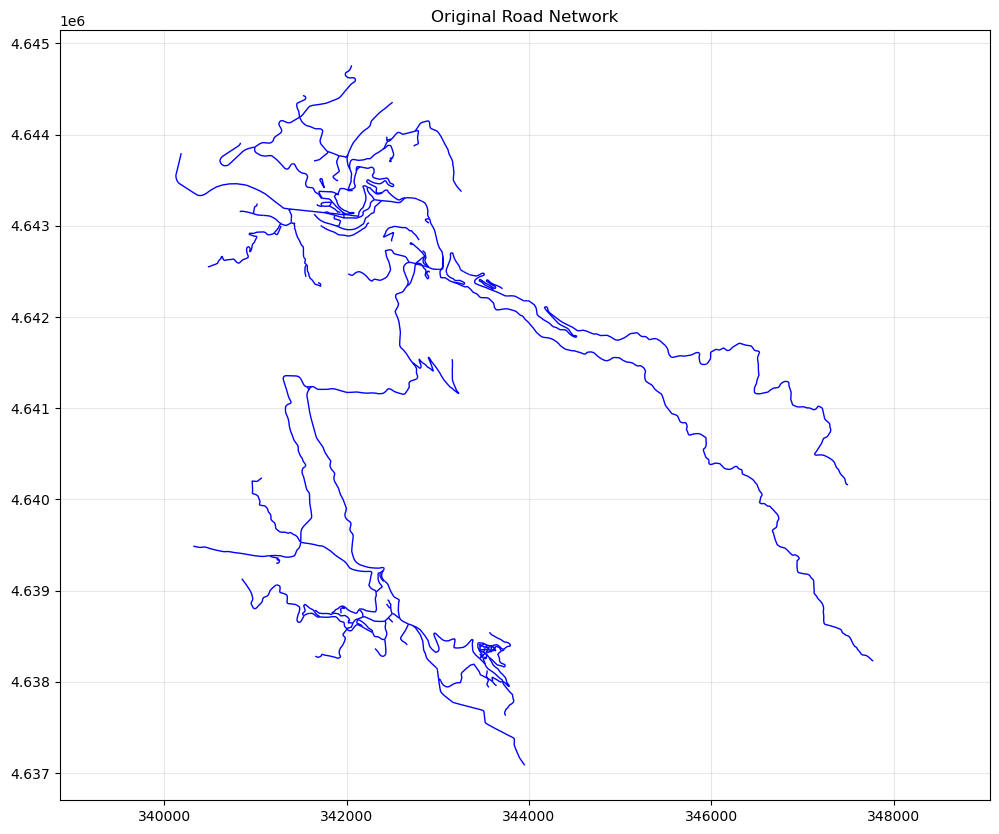

In [8]:
# Visualize the original road network
fig, ax = plt.subplots(figsize=(12, 10))
road_network.plot(ax=ax, color='blue', linewidth=1)
ax.set_title('Original Road Network')
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.show()

In [9]:
# Check geometry types
geometry_types = road_network.geometry.type.value_counts()
print("Geometry types in the dataset:")
print(geometry_types)

# Count MultiLineStrings if present
if 'MultiLineString' in geometry_types.index:
    multi_line_count = geometry_types['MultiLineString']
    print(f"\nFound {multi_line_count} MultiLineString features")
    
    # Get a sample MultiLineString for demonstration
    multi_line_sample = road_network[road_network.geometry.type == 'MultiLineString'].iloc[0]
    print(f"\nSample MultiLineString properties:")
    print(f"Number of parts: {len(list(multi_line_sample.geometry.geoms))}")
    print(f"Total length: {multi_line_sample.geometry.length:.2f} meters")

Geometry types in the dataset:
MultiLineString    330
dtype: int64

Found 330 MultiLineString features

Sample MultiLineString properties:
Number of parts: 1
Total length: 10.70 meters


## 3. Basic Road Segmentation Testing <a id="basic-testing"></a>

Let's test the `segment_road` function on a single LineString to understand the segmentation process.

In [10]:
# Get a sample LineString for testing
sample_line = None
for idx, road in road_network.iterrows():
    if isinstance(road.geometry, LineString) and road.geometry.length > 300:
        sample_line = road.geometry
        sample_id = idx
        break
        
if sample_line is None:
    # If no suitable LineString found, take the first row and convert to LineString if needed
    sample_road = road_network.iloc[3]
    if isinstance(sample_road.geometry, MultiLineString):
        sample_line = LineString([p for line in sample_road.geometry.geoms for p in line.coords])
    else:
        sample_line = sample_road.geometry
    sample_id = 0

print(f"Selected sample road with ID {sample_id} for segmentation testing")
print(f"Sample road length: {sample_line.length:.2f} meters")

Selected sample road with ID 0 for segmentation testing
Sample road length: 342.58 meters


In [13]:
# Test segment_road function with different segment lengths
segment_lengths = [100, 200]
segmentation_results = {}

for length in segment_lengths:
    start_time = time.time()
    segments = segment_road(sample_line, segment_length=length)
    end_time = time.time()
    
    segmentation_results[length] = {
        'segments': segments,
        'count': len(segments),
        'time': end_time - start_time,
        'lengths': [seg.length for seg in segments]
    }
    
    print(f"Segment length: {length}m")
    print(f"  Number of segments: {len(segments)}")
    print(f"  Segmentation time: {end_time - start_time:.4f} seconds")
    if segments:
        min_length = min(seg.length for seg in segments)
        max_length = max(seg.length for seg in segments)
        avg_length = sum(seg.length for seg in segments) / len(segments)
        print(f"  Min segment length: {min_length:.2f}m")
        print(f"  Max segment length: {max_length:.2f}m")
        print(f"  Avg segment length: {avg_length:.2f}m")
        print(f"  Length difference (max/min): {max_length/min_length:.2f}x")
    print()

Segment length: 100m
  Number of segments: 4
  Segmentation time: 0.0014 seconds
  Min segment length: 85.64m
  Max segment length: 85.64m
  Avg segment length: 85.64m
  Length difference (max/min): 1.00x

Segment length: 200m
  Number of segments: 2
  Segmentation time: 0.0005 seconds
  Min segment length: 171.29m
  Max segment length: 171.29m
  Avg segment length: 171.29m
  Length difference (max/min): 1.00x



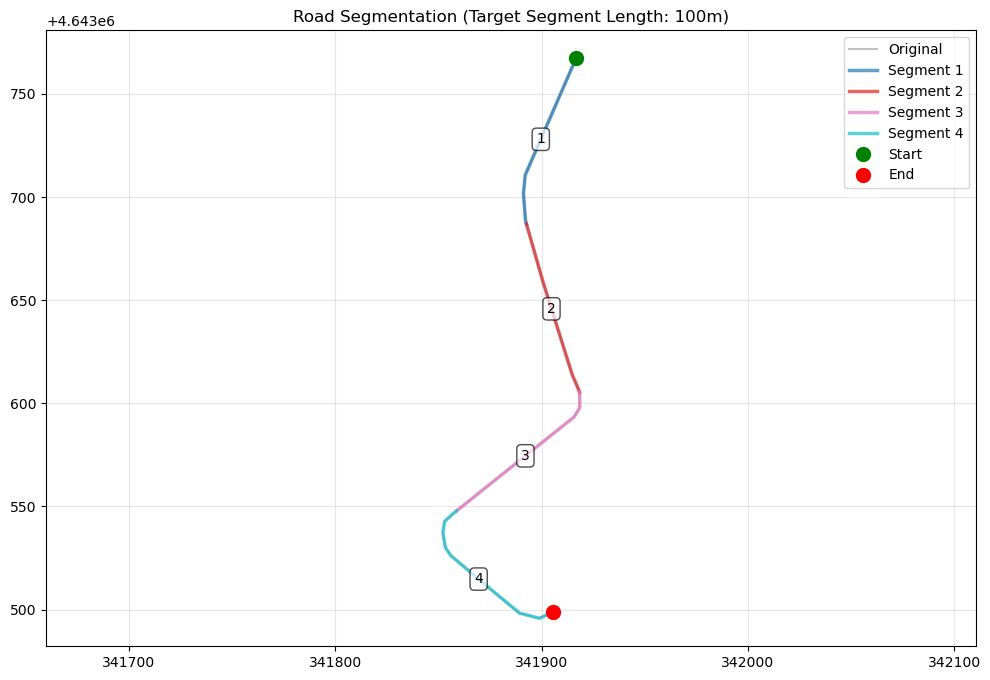

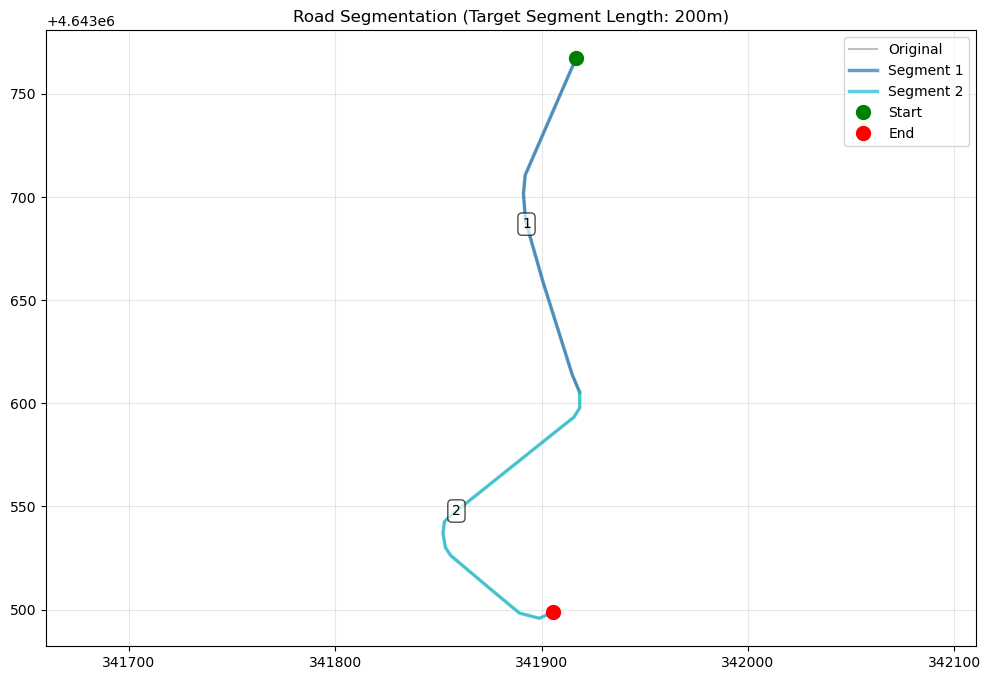

In [14]:
# Visualize segmentation results
def plot_segmentation(original_line, segments, title):
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Plot original line
    x, y = original_line.xy
    ax.plot(x, y, color='gray', linewidth=1.5, alpha=0.5, label='Original')
    
    # Plot segments with different colors
    colors = plt.cm.tab10(np.linspace(0, 1, len(segments)))
    for i, segment in enumerate(segments):
        x, y = segment.xy
        ax.plot(x, y, color=colors[i], linewidth=2.5, alpha=0.7, label=f'Segment {i+1}')
        
        # Add segment midpoint labels
        mid_point = segment.interpolate(0.5, normalized=True)
        ax.text(mid_point.x, mid_point.y, str(i+1), ha='center', va='center', 
                bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.3'))
    
    # Add start point
    start_point = Point(original_line.coords[0])
    ax.plot(start_point.x, start_point.y, 'go', markersize=10, label='Start')
    
    # Add end point
    end_point = Point(original_line.coords[-1])
    ax.plot(end_point.x, end_point.y, 'ro', markersize=10, label='End')
    
    ax.set_title(title)
    plt.grid(True, alpha=0.3)
    plt.axis('equal')
    plt.legend(loc='best')
    plt.show()

# Plot for each segment length
for length, result in segmentation_results.items():
    plot_segmentation(sample_line, result['segments'], 
                      f'Road Segmentation (Target Segment Length: {length}m)')

## Segmenting the entire road network

In [18]:
# Check if road_network has ID column
if 'ID' not in road_network.columns and 'id' not in road_network.columns:
    road_network['id'] = range(1, len(road_network) + 1)
    id_column = 'id'
else:
    id_column = 'ID' if 'ID' in road_network.columns else 'id'

In [29]:
# Set segment length for road network segmentation
segment_length = 200
# Segment the entire road network
road_segments = segment_road_network(
    road_network,
    segment_length=segment_length,
    id_column=id_column,
    preserve_attributes=True
    )

print("Road Network Segmentation Completed")

2025-04-29 18:24:07,811 - src.road.segmentation - INFO - Processing MultiLineString with 1 parts at index 0
2025-04-29 18:24:07,812 - src.road.segmentation - INFO - Processing MultiLineString with 1 parts at index 1
2025-04-29 18:24:07,812 - src.road.segmentation - INFO - Processing MultiLineString with 1 parts at index 2
2025-04-29 18:24:07,814 - src.road.segmentation - INFO - Processing MultiLineString with 1 parts at index 3
2025-04-29 18:24:07,815 - src.road.segmentation - INFO - Processing MultiLineString with 1 parts at index 4
2025-04-29 18:24:07,815 - src.road.segmentation - INFO - Processing MultiLineString with 1 parts at index 5
2025-04-29 18:24:07,816 - src.road.segmentation - INFO - Processing MultiLineString with 1 parts at index 6
2025-04-29 18:24:07,817 - src.road.segmentation - INFO - Processing MultiLineString with 1 parts at index 7
2025-04-29 18:24:07,818 - src.road.segmentation - INFO - Processing MultiLineString with 1 parts at index 8
2025-04-29 18:24:07,818 - sr

Road Network Segmentation Completed


In [34]:
road_segments['segment_length'].describe()

count    594.000000
mean     126.432141
std       67.881147
min        1.071572
25%       65.431350
50%      150.886079
75%      185.578100
max      199.419608
Name: segment_length, dtype: float64

In [35]:
output_dir = data_dir / "intermediate"

write_vector(road_segments,
             output_path=output_dir / "road_segments.gpkg",
             driver="GPKG"
)